In [293]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import pickle


## Importing data

In [160]:
app=pd.read_csv('/content/drive/MyDrive/Untitled folder/Reunion assignment/applicant.csv')
loan=pd.read_csv('/content/drive/MyDrive/Untitled folder/Reunion assignment/loan.csv')

## Preprocessing

In [161]:
print(app['Balance_in_existing_bank_account_(lower_limit_of_bucket)'].isna().sum(), app['Balance_in_existing_bank_account_(upper_limit_of_bucket)'].isna().sum())
print(loan['Property'].isna().sum())


668 457
154


In [162]:
# Almost half of the values in these columns were null, therefore dropping them and applicant_id

app.drop(['Balance_in_existing_bank_account_(lower_limit_of_bucket)','Balance_in_existing_bank_account_(upper_limit_of_bucket)','applicant_id'], axis=1,inplace=True)

In [163]:
# Removing ids from loan.csv data
loan.drop(['loan_application_id','applicant_id'],axis=1,inplace=True)

In [164]:
app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Primary_applicant_age_in_years  1000 non-null   int64 
 1   Gender                          1000 non-null   object
 2   Marital_status                  1000 non-null   object
 3   Number_of_dependents            1000 non-null   int64 
 4   Housing                         1000 non-null   object
 5   Years_at_current_residence      1000 non-null   int64 
 6   Employment_status               1000 non-null   object
 7   Has_been_employed_for_at_least  938 non-null    object
 8   Has_been_employed_for_at_most   747 non-null    object
 9   Savings_account_balance         817 non-null    object
 10  high_risk_applicant             1000 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 86.1+ KB


In [165]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   Months_loan_taken_for                        1000 non-null   int64 
 1   Purpose                                      988 non-null    object
 2   Principal_loan_amount                        1000 non-null   int64 
 3   EMI_rate_in_percentage_of_disposable_income  1000 non-null   int64 
 4   Property                                     846 non-null    object
 5   Number_of_existing_loans_at_this_bank        1000 non-null   int64 
 6   Loan_history                                 1000 non-null   object
 7   high_risk_applicant                          1000 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 62.6+ KB


.

## Converting text to numbers for correlation matrix

In [166]:
#savings has Nan elements therefore filling the column with "0"

app['Savings_account_balance'] = app['Savings_account_balance'].fillna(0)
app['Has_been_employed_for_at_least']=app['Has_been_employed_for_at_least'].fillna(0)

In [167]:
#these attributes can be important to find the correaltions, therefore converting text to numbers

gender = {'male': 1,'female': 2}
marital={'divorced/separated':1,'divorced/separated/married':2,'married/widowed':3,'single':4}
saving={'Low':1,'Medium':2,'High':3,'Very high':4,0:0}
employ_status={'management / self-employed / highly qualified employee / officer':1,'skilled employee / official':2,'unemployed / unskilled - non-resident':3,'unskilled - resident':4}
house={'for free':1,'own':2,'rent':3}
atleast_employed={'0 year':0,'1 year':1,'4 years':4,'7 years':7,0:0}

app.Gender = [gender[item] for item in app.Gender]
app.Marital_status=[marital[item] for item in app.Marital_status]
app.Savings_account_balance=[saving[item] for item in app.Savings_account_balance]
app.Employment_status=[employ_status[item] for item in app.Employment_status]
app.Housing=[house[item] for item in app.Housing]
app.Has_been_employed_for_at_least=[atleast_employed[item] for item in app.Has_been_employed_for_at_least]

In [168]:
app.drop(['Has_been_employed_for_at_most'],axis=1,inplace=True)

In [169]:
app.head()

,Primary_applicant_age_in_years,Gender,Marital_status,Number_of_dependents,Housing,Years_at_current_residence,Employment_status,Has_been_employed_for_at_least,Savings_account_balance,high_risk_applicant
0,43,1,1,1,2,3,1,0,1,0
1,40,1,1,1,2,4,1,1,1,0
2,26,1,1,1,2,1,2,1,3,0
3,31,1,1,1,2,2,4,1,1,0
4,36,1,1,1,2,4,2,1,4,0


In [170]:
# Property or collateral can play important role in determining creditness of an applicanr

loan['Property'] = loan['Property'].fillna(0)
prop={'building society savings agreement/life insurance':1,'car or other':2,'real estate':3,0:0}

loan.Property=[prop[item] for item in loan.Property]

In [171]:
loan.drop(['Purpose','Loan_history'],axis=1,inplace=True)

In [172]:
loan.head()

,Months_loan_taken_for,Principal_loan_amount,EMI_rate_in_percentage_of_disposable_income,Property,Number_of_existing_loans_at_this_bank,high_risk_applicant
0,18,1941000,4,1,1,0
1,48,8358000,1,2,2,0
2,36,3990000,3,0,1,0
3,18,1568000,3,1,1,0
4,24,1193000,1,0,2,1


.

## Correlation Matrix

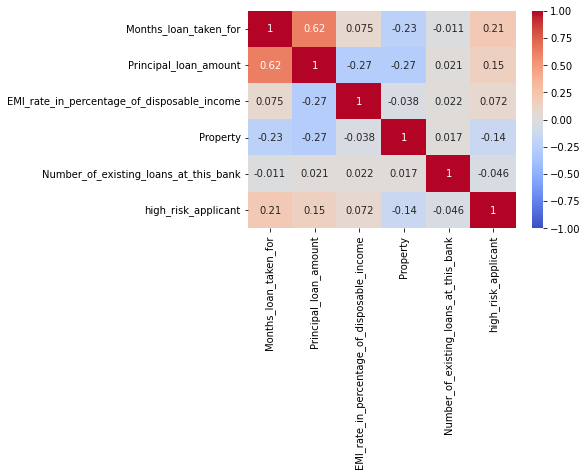

In [173]:
# Heatmap for loan.csv
dataplot = sns.heatmap(loan.corr(), annot=True, vmin=-1, vmax=1, cmap='coolwarm')
plt.show()

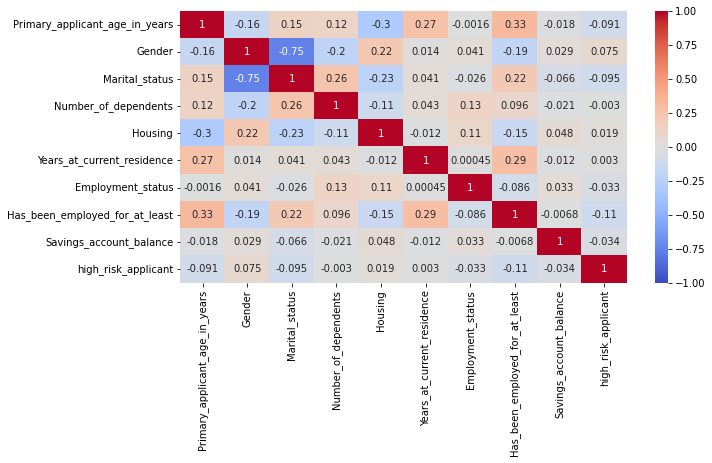

In [174]:
# Heatmap for applicant.csv
dataplot = sns.heatmap(app.corr(), annot=True, vmin=-1, vmax=1, cmap= 'coolwarm')
fig = plt.gcf()
fig.set_size_inches(10,5)
plt.show()

## Train-Test Split

In [139]:
# It makes no sense to remove two correlated variables, unless correlation=1 or -1, in which case one of the variables is redundant.
# Therefore, in the next step spliting the data into train_test

In [210]:
x = app.drop(['high_risk_applicant'], axis=1)
y = app['high_risk_applicant']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [211]:
x_train.shape, x_test.shape

((800, 9), (200, 9))

.

## 1. Naive Bayes

In [212]:
# train a Gaussian Naive Bayes classifier on the training set
from sklearn.naive_bayes import GaussianNB

# instantiate the model
gnb = GaussianNB()

# fit the model
gnb.fit(x_train, y_train)

GaussianNB()

In [213]:
y_pred = gnb.predict(x_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0])

In [214]:
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score: 0.6550


In [215]:
y_pred_train = gnb.predict(x_train)
y_pred_train[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [216]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.6925


Confusion Matrix

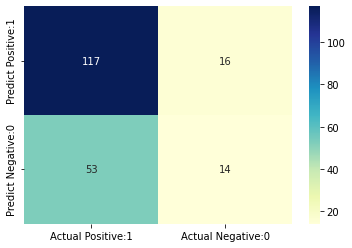

In [217]:
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')


.

## 2. K-Nearest Neighbours

In [280]:
# instantiate the model
knn = KNeighborsClassifier(n_neighbors=6)

# fit the model to the training set
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=6)

In [281]:
y_pred2 = knn.predict(x_test)

y_pred2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [282]:
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred2)))

Model accuracy score: 0.6650


In [283]:
y_pred_train = knn.predict(x_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.7300


Confusion Matrix

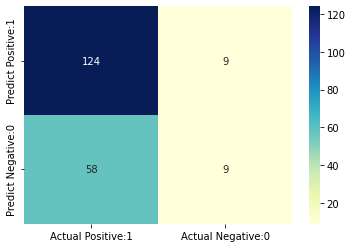

In [284]:
cm = confusion_matrix(y_test, y_pred2)
plt.figure(figsize=(6,4))

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

.

## 3. Random Forest

In [285]:
rfc = RandomForestClassifier(n_estimators=100,random_state=4)
rfc.fit(x_train, y_train)

RandomForestClassifier(random_state=4)

In [286]:
y_pred3 = rfc.predict(x_test)

In [287]:
print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred3)))

Model accuracy score with 10 decision-trees : 0.6550


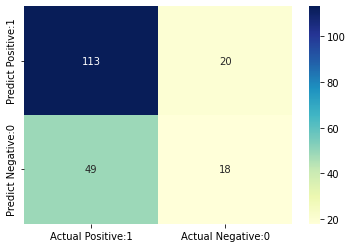

In [288]:
cm = confusion_matrix(y_test, y_pred3)
plt.figure(figsize=(6,4))

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

.

## 4. Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train, y_train)

In [296]:
y_pred4 = lr.predict(x_test)

In [297]:
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred4)))

Model accuracy score: 0.6650


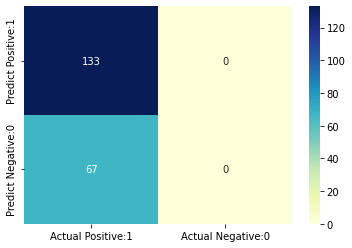

In [298]:
cm = confusion_matrix(y_test, y_pred4)
plt.figure(figsize=(6,4))

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

.

## Saving model

In [299]:
pickle.dump(lr, open('log_reg.pkl', 'wb'))         #logistic model
pickle.dump(knn, open('knn.pkl', 'wb'))            #knn model
pickle.dump(gnb, open('naive_bayes.pkl', 'wb'))    #naive bayes model 
pickle.dump(rfc, open('random_forest.pkl', 'wb'))  #random forest model

# Conclusion

Linear Regression and K-NN model performed best as their accuracy was higher than the other two models